# Introduction

In the world of computer vision and deep learning, the **"ImageNet Classification with Deep Convolutional Neural Networks"** paper represents a significant milestone. Published in 2012 by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, this paper revolutionized the field by introducing a deep convolutional neural network (CNN) architecture that achieved state-of-the-art results in the ImageNet Large Scale Visual Recognition Challenge. This marked the beginning of the deep learning era in computer vision.

AlexNet is credited with popularizing deep neural networks and demonstrating their capabilities in image classification tasks. Its architecture, which consists of multiple convolutional layers, max-pooling layers, and fully connected layers, laid the foundation for many subsequent CNN architectures like VGG, ResNet, and Inception.

In this Jupyter notebook project, we will embark on a journey to understand, implement, and analyze the AlexNet architecture.


# CIFAR-10 Dataset

In the original research paper, the authors conducted experiments utilizing a subset of the extensive ImageNet dataset, the subset comprises over 1.2 million images spanning 1000 distinct classes.

For the scope of this project, our primary objective is to delve into the intricacies of the AlexNet architecture and its underlying mechanisms. Consequently, we will employ CIFAR-10, which is a more manageable dataset, featuring only 10 classes, each containing 6000 images. In particular, we will use only 3000 training images per class, 300 validation images per class and 600 testing images per class. This simplified dataset will enable us to comprehensively explore and grasp the workings of AlexNet while minimizing computational demands.

In [1]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10(root='./data', train=True, download=True, transform=None)
test_data = CIFAR10(root='./data', train=False, download=True, transform=None)

LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(LABEL_NAMES)

100%|██████████| 170498071/170498071 [00:03<00:00, 43599723.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import numpy as np

# Get the train targets
train_targets = np.array(train_data.targets)

# Get the train targets
test_targets = np.array(test_data.targets)

In [3]:
# Number of samples per class for the training set
num_train_samples_per_class = 3000

# Number of samples per class for the validation set
num_valid_samples_per_class = 300

# Number of samples per class for the test set
num_test_samples_per_class = 600

In [4]:
train_indices = []
valid_indices = []
test_indices = []

for class_idx in range(NUM_CLASSES):
    # for each class idx
    # get the indices of the samples with the same class

    ### Train indices
    class_indices = np.where(train_targets == class_idx)[0]
    class_train_indices = class_indices[:num_train_samples_per_class]
    train_indices.extend(list(class_train_indices))

    ### Test and Validation indices
    # Note : the test and validation subsets are disjoint
    #      : because the CIFAR-10 test dataset is many times
    #      : greater than our test/validation sets

    class_indices = np.where(test_targets == class_idx)[0]

    # Validation indices
    class_valid_indices = class_indices[:num_valid_samples_per_class]
    valid_indices.extend(list(class_valid_indices))

    # Test indices
    class_test_indices = class_indices[-num_test_samples_per_class:]
    test_indices.extend(list(class_test_indices))

# Sanity check
assert len(train_indices) == NUM_CLASSES * num_train_samples_per_class
assert len(valid_indices) == NUM_CLASSES * num_valid_samples_per_class
assert len(test_indices) == NUM_CLASSES * num_test_samples_per_class

### Test and Validation indices
#   were chosen from the same test set
#   lets make sure they are disjoint

# Disjointness check
assert len(set(test_indices).intersection(set(valid_indices))) == 0

In [5]:
# Get the train, valid and test samples
train_samples = [train_data[i] for i in train_indices]
valid_samples = [test_data[i] for i in valid_indices]
test_samples = [test_data[i] for i in test_indices]

# Delete unnecessary variables
del train_data
del test_data
del train_indices
del valid_indices
del test_indices

In [6]:
import torch
from torch.utils.data import Dataset

class customCIFAR(Dataset):
    """
    Custom dataset for CIFAR-10 image data.

    Args:
        data (List[Tuple]): List of data samples in the form (PIL Image, Labels).

    Attributes:
        data (List[Tuple]): List of data samples.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__: Returns a sample (image, label) by index.

    """
    def __init__(self, data):
        """
        Initialize the customCIFAR dataset with image and label data.

        Args:
            data (List[Tuple]): List of data samples in the form (PIL Image, Labels).
        """
        self.data = data

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a sample (image, label) by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            torch.Tensor: Preprocessed image data.
            int: Label for the image.
        """
        image, label = self.data[idx]
        image = image.resize((227, 227))
        image = np.asarray(image) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        return image, label

train_dataset = customCIFAR(train_samples)
valid_dataset = customCIFAR(valid_samples)
test_dataset = customCIFAR(test_samples)

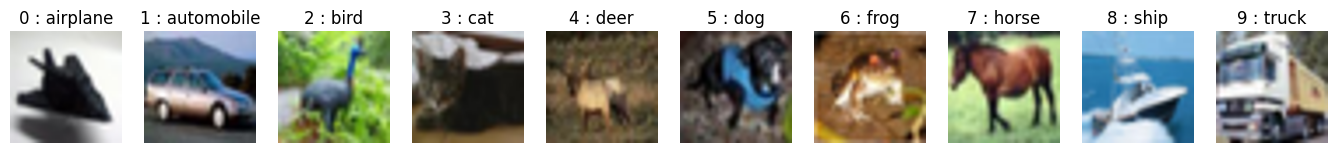

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 10, figsize=(17, 3))
for i in range(10):
    img, label = train_dataset[i * num_train_samples_per_class]
    img = np.transpose(img, (1, 2, 0))
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"{label} : {LABEL_NAMES[label]}")
    axes[i].axis('off')
plt.show()

# AlexNet Architecture

<div align="center">
<img src="./resources/alexnet.png">
</div>

As we examine the architecture of AlexNet as described in the original <a href="https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf">paper</a>, we observe that it comprises a total of 8 layers: 5 convolutional layers and 3 fully connected layers. The initial two convolutional layers are succeeded by max-pooling layers, and the final convolutional layer is trailed by another max-pooling layer. Subsequently, three fully connected layers follow, culminating in the output layer consisting of 1000 neurons, corresponding to the 1000 classes in the subset of the ImageNet dataset used in the study.

Furthermore, we notice that certain layers in the original architecture incorporate a technique known as local response normalization (LRN) to normalize the outputs of the preceding layer. However, subsequent research papers like <a href="https://arxiv.org/abs/1502.03167">"Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"</a> have discredited the effectiveness of this approach, leading to its exclusion from later architectures.

Another noteworthy detail pertains to the connectivity pattern of certain layers. Specifically, the kernels in layer 3 receive input from all kernel maps in layer 2. Conversely, in layer 4, kernels only take input from kernel maps within the same GPU.

In our implementation of AlexNet, we are introducing several noteworthy modifications:


- We will substitute the original output layer with a fully connected layer comprising 10 neurons, aligning it with the 10 classes present in the CIFAR-10 dataset.
- Instead of utilizing LRN (Local Response Normalization) layers as seen in the original paper, we will employ batch normalization layers. Batch normalization has exhibited superior effectiveness in normalization, and we will apply it after each convolutional layer. This contrasts with the original design, which utilized LRN primarily after the first and second convolutional layers.
- We will embrace a more interconnected architecture among layers, facilitating each kernel within a layer to accept input from all kernel maps in the preceding layer. This departure from the original design, which confined input connections to kernels residing within the same GPU, allows for enhanced information flow and interlayer communication (Especially since today's computers can handle it!).


These adjustments highlight the evolution and optimization of the AlexNet architecture to suit contemporary best practices.

In [8]:
import torch.nn as nn

class AlexNet(nn.Module):
    """
    AlexNet architecture for image classification.

    Args:
        num_classes (int): Number of output classes.

    Attributes:
        layer1, layer2, layer3, layer4, layer5 (nn.Sequential): Convolutional layers.
        fc, fc1, fc2 (nn.Sequential): Fully connected layers.

    Methods:
        forward: Forward pass through the network.

    """
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Train

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import json

# Define a training function using the Adam optimizer
def train(model, train_loader, valid_loader, num_epochs, learning_rate, weight_decay, momentum, saving_freq, patience, output_file):
    """
    Train a neural network model.

    Args:
        model (nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader for training data.
        valid_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): L2 regularization term.
        momentum (float): Momentum for the optimizer.
        saving_freq (int): Frequency (in epochs) to save the model.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        output_file (str): Name of the output file to store training scores.

    Returns:
        None
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_valid_loss = float('inf')
    no_improvement = 0  # Early stopping counter

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 100 == 99:  # Print every 10 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        valid_accuracy = accuracy_score(all_targets, all_preds)
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(valid_accuracy)

        print(f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')

        # Early stopping based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

        # Save the model every saving_freq epochs
        if (epoch + 1) % saving_freq == 0:
            model_save_name = f'./outputs/model_{epoch + 1}.pt'
            torch.save(model.state_dict(), model_save_name)
            print(f'Saved model as {model_save_name}')

    # Save train and validation scores to a JSON file
    scores = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "valid_accuracies": valid_accuracies
    }

    with open('./outputs/' + output_file, 'w') as json_file:
        json.dump(scores, json_file)

    print('Training finished.')

In [10]:
from torch.utils.data import DataLoader
import os

# Define the train data loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Define device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a model instance
model = AlexNet().to(device)

# Create output folder if it doesn't exist
os.makedirs("outputs", exist_ok=True)

# Training params
num_epochs = 20
learning_rate = 0.005
weight_decay = 0.005
momentum = 0.9

# Training
train(
    model = model,
    train_loader = train_loader,
    valid_loader = valid_loader,
    num_epochs = num_epochs,
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    momentum = momentum,
    saving_freq = 5,
    patience = 5,
    output_file = 'metrics.json'
    )

Epoch [1/20], Batch [100/235], Loss: 1.7564
Epoch [1/20], Batch [200/235], Loss: 1.3460
Validation Loss: 1.5217, Validation Accuracy: 0.4817
Epoch [2/20], Batch [100/235], Loss: 1.1398
Epoch [2/20], Batch [200/235], Loss: 1.0460
Validation Loss: 0.9934, Validation Accuracy: 0.6450
Epoch [3/20], Batch [100/235], Loss: 0.9284
Epoch [3/20], Batch [200/235], Loss: 0.8679
Validation Loss: 1.0204, Validation Accuracy: 0.6343
Epoch [4/20], Batch [100/235], Loss: 0.7853
Epoch [4/20], Batch [200/235], Loss: 0.7699
Validation Loss: 0.9414, Validation Accuracy: 0.6720
Epoch [5/20], Batch [100/235], Loss: 0.6850
Epoch [5/20], Batch [200/235], Loss: 0.6809
Validation Loss: 0.9521, Validation Accuracy: 0.6733
Saved model as ./outputs/model_5.pt
Epoch [6/20], Batch [100/235], Loss: 0.6317
Epoch [6/20], Batch [200/235], Loss: 0.6205
Validation Loss: 0.8274, Validation Accuracy: 0.7160
Epoch [7/20], Batch [100/235], Loss: 0.5622
Epoch [7/20], Batch [200/235], Loss: 0.5605
Validation Loss: 1.0699, Valid

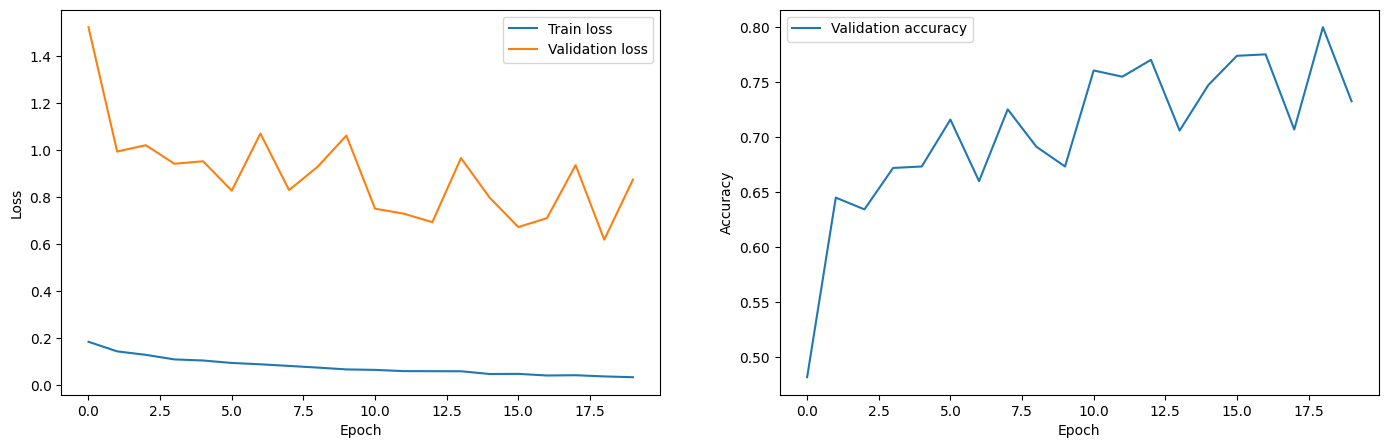

In [11]:
# Visualize the training and validation losses
import json
import matplotlib.pyplot as plt

with open('./outputs/metrics.json') as json_file:
    scores = json.load(json_file)

train_losses = scores['train_losses']
valid_losses = scores['valid_losses']
valid_accuracies = scores['valid_accuracies']

fig, axes = plt.subplots(1, 2, figsize=(17, 5))
axes[0].plot(train_losses, label='Train loss')
axes[0].plot(valid_losses, label='Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(valid_accuracies, label='Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()

As evident from the results, there is a notable disparity between the training and validation losses, signifying a significant difference in model performance on the two datasets. This rapid convergence during training aligns with the observations made by the authors, who noted the model's tendency to quickly succumb to overfitting. To address this challenge, they employed dropout, a technique that `"reduces complex co-adaptations of neurons, since a neuron cannot rely on the presence of particular other neurons. It is, therefore, forced to learn more robust features that are useful in conjunction with many different random subsets of the other neurons"`

Additionally, the authors augmented their data, effectively increasing the dataset's size by a factor of 2048 which helped them avoid the use of smaller architectures (`"Without this scheme, our network suffers from substantial overfitting, which would have forced us to use much smaller networks."`). Given that our dataset is comparatively much smaller, it is unsurprising that our model also exhibits rapid convergence during training. Consequently, this leads to a significant discrepancy between the training and validation loss, underscoring the impact of dataset size on model generalization.

# Test

In [12]:
import torch

# Define a test function
def test(model, test_loader):
    """
    Evaluate a neural network model on a test set.

    Args:
        model (nn.Module): The trained neural network model.
        test_loader (DataLoader): DataLoader for the test data.

    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the same device as inputs

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)  # Ensure targets are on the same device

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update counts for correct and total predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


In [13]:
# Define the test data loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test(model, test_loader)

Test Accuracy: 73.93%


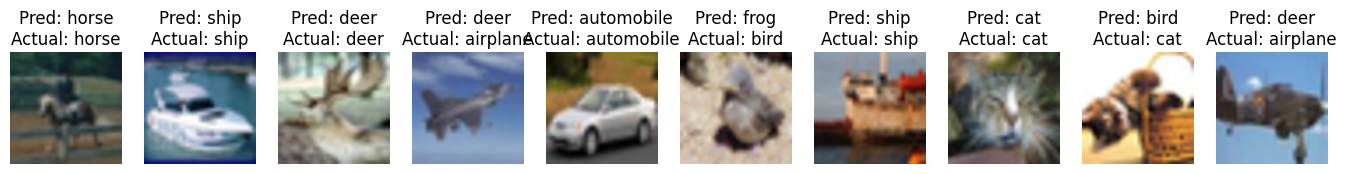

In [14]:
import random

def plot_random_predictions(model, data_loader, label_names, device):
    """
    Plot random predictions for a given model.

    Args:
        model (nn.Module): The trained neural network model.
        data_loader (DataLoader): DataLoader for the data.
        label_names (list): List of label names.
        device (torch.device): Device to perform computations on.

    Returns:
        None
    """
    model.eval()

    # Get random samples from the data loader
    random_samples = random.sample(range(len(data_loader.dataset)), 10)

    fig, axes = plt.subplots(1, 10, figsize=(17, 3))
    for i, idx in enumerate(random_samples):
        img, label = data_loader.dataset[idx]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img)
        _, predicted = torch.max(output, 1)

        img = img.squeeze().cpu().numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {label_names[predicted.item()]}\nActual: {label_names[label]}")
        axes[i].axis('off')

    plt.savefig("./outputs/inference.png")
    plt.show()

plot_random_predictions(model, test_loader, LABEL_NAMES, device)

In our evaluation on a test dataset consisting of 600 sample images, our model achieved an impressive accuracy rate of 74%. This result is particularly noteworthy when compared to the original research findings, where the authors achieved an accuracy of 89% using a similar architecture with four convolutional layers on the full CIFAR-10 dataset `"We also verified the effectiveness of this scheme on the CIFAR-10 dataset: a four-layer
CNN achieved a 13% test error rate without normalization and 11% with normalization"`. Our accomplishment demonstrates the effectiveness of the model and its ability to perform remarkably well, even with a simplified architecture and a smaller dataset.